### Developer: Mayana Mohsin Khan

# Multiclass Perceptron
### Loading the Packages

In [14]:
# load the required libraries
library(reshape2)
library(ggplot2)

### I. Loading the dataset

In [15]:
# reading the data
read_data <- function(fname) {
   data <- read.csv(file=fname,head=TRUE,sep=",")
   row = dim(data)[1]
   col = dim(data)[2]
   x = data[1:row,1:(col-1)]
   y = data[1:row,col]
   
   # transform both predictors and target variable
   x = cbind(1,x) # take 1 as x0 column
    
   # create a matrix 
   x = as.matrix(x) 
    
   # take the last char or num as true value 
   y = as.numeric(substr(y, 2, 2)) 
   return (list("x" = x, "y" = y))
}

#### Axuliary functions

In [16]:
# predict function
predictP <- function(Phi, W){
    # matrix to prediction
    arg <- matrix(,nrow=nrow(Phi), ncol=nrow(W))
    
    # calculate prediction for each classifier
    for (i in 1:nrow(W)){
        arg[,i] <- Phi %*% W[i,]
    }
    
    # get the maximum argument class 
    argmax <- max.col(arg,ties.method = 'first') 
    return(argmax)
}

In [17]:
# train objective function (accuracy)
train_objective <- function(data, W, label) {
    # prediction
    pred <- predictP(data, W)
    
    # count the missclassified datapoints
    missclass <- sum((pred-label) != 0)
    
    # return the percentage of missclassification
    return (missclass / nrow(data) * 100)
}

In [18]:
# error function
get_errors <- function(train_data, test_data, W) {
   # get the number of mini batches (tau) 
   n_weights = dim(W)[1] 
   # set storing matrix
   errors = matrix(,nrow=n_weights, ncol=2) 
   # calculate error using W stored on each mini batch trained
   for (tau in 1:n_weights) {
      errors[tau,1] = train_objective(train_data$x,W[tau,,], train_data$y) 
      errors[tau,2] = train_objective(test_data$x,W[tau,,], test_data$y)   
   }
   return(errors)
}

In [19]:
# tmulticlass training function
train_multiclass_perceptron <- function (dtrain,dtest, eta=.01, epsilon=.001, tau.max=1500){
    # store the length of both datasets
    train.len <- nrow(dtrain$x)
    test.len <- nrow(dtest$x)
    # number of classes
    K <- length(unique(dtrain$y)) 

    # 3D array for weight that has dimension of tau_max . K . length of phi
    W <- array(numeric(),dim=c(tau.max,K,ncol(dtrain$x))) # Empty Weight vector
    for (i in 1:K){
        # Random initial values for weight vector
        W[1,i,] <- runif(ncol(dtrain$x)) 
    }
    # termination status
    terminate <- FALSE 
    tau <- 1 # counter for iteration
    
    while(!terminate){
        
        # resuffling train data 
        train.index <- sample(1:train.len, replace = FALSE)
        
        # creating batches indexes
        batchs <- cut(seq(1,train.len),breaks=train.len/5, labels = FALSE)
        
        # loop through for each batch
        for (i in 1:max(batchs)){
            # check termination condition
            if (tau == tau.max) {break} 
            
            # get the current batch indexes
            batch.ind <- train.index[which(batchs==i, arr.ind=TRUE)]
            
            # specify shuffled indexes for data in this batch
            Phi <- dtrain$x[batch.ind,]
            T <- dtrain$y[batch.ind]
            
            # store the last batch
            batch.W <- W[tau,,]
            
            # loop through for each datapoint in the current batch
            for (j in 1:length(batch.ind)){
                
                currPhi <- t(as.matrix(Phi[j,])) # current datapoint
                
                pred <- predictP(currPhi,batch.W) # predictio using current datapoint and W
                
                # look for missclassified samples
                if (pred!=T[j]){
                    # update the current batch weights
                    batch.W[pred,] <- batch.W[pred,] - eta * currPhi # W of prediction class classifier
                    batch.W[T[j],] <- batch.W[T[j],] + eta * currPhi # W of true class classifier
                }
            }
            # update tau counter
            tau <- tau+1
            
            # put trained W in current batch to overall W matrix
            W[tau,,] <- batch.W
        }
        # decrease eta:
        eta = eta * 0.99
        
        # recalculate termination conditions
        terminate <- tau >= tau.max | train_objective(dtrain$x,W[tau,,],T) <= epsilon
    }
    
    # calculate error using all trained W
    errors <- get_errors(dtrain, dtest, W)
    return(errors)
}

I. Load Training and Testing data

III. Use Multiclass Perceptron Algorithm with 2 Different eta's values

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


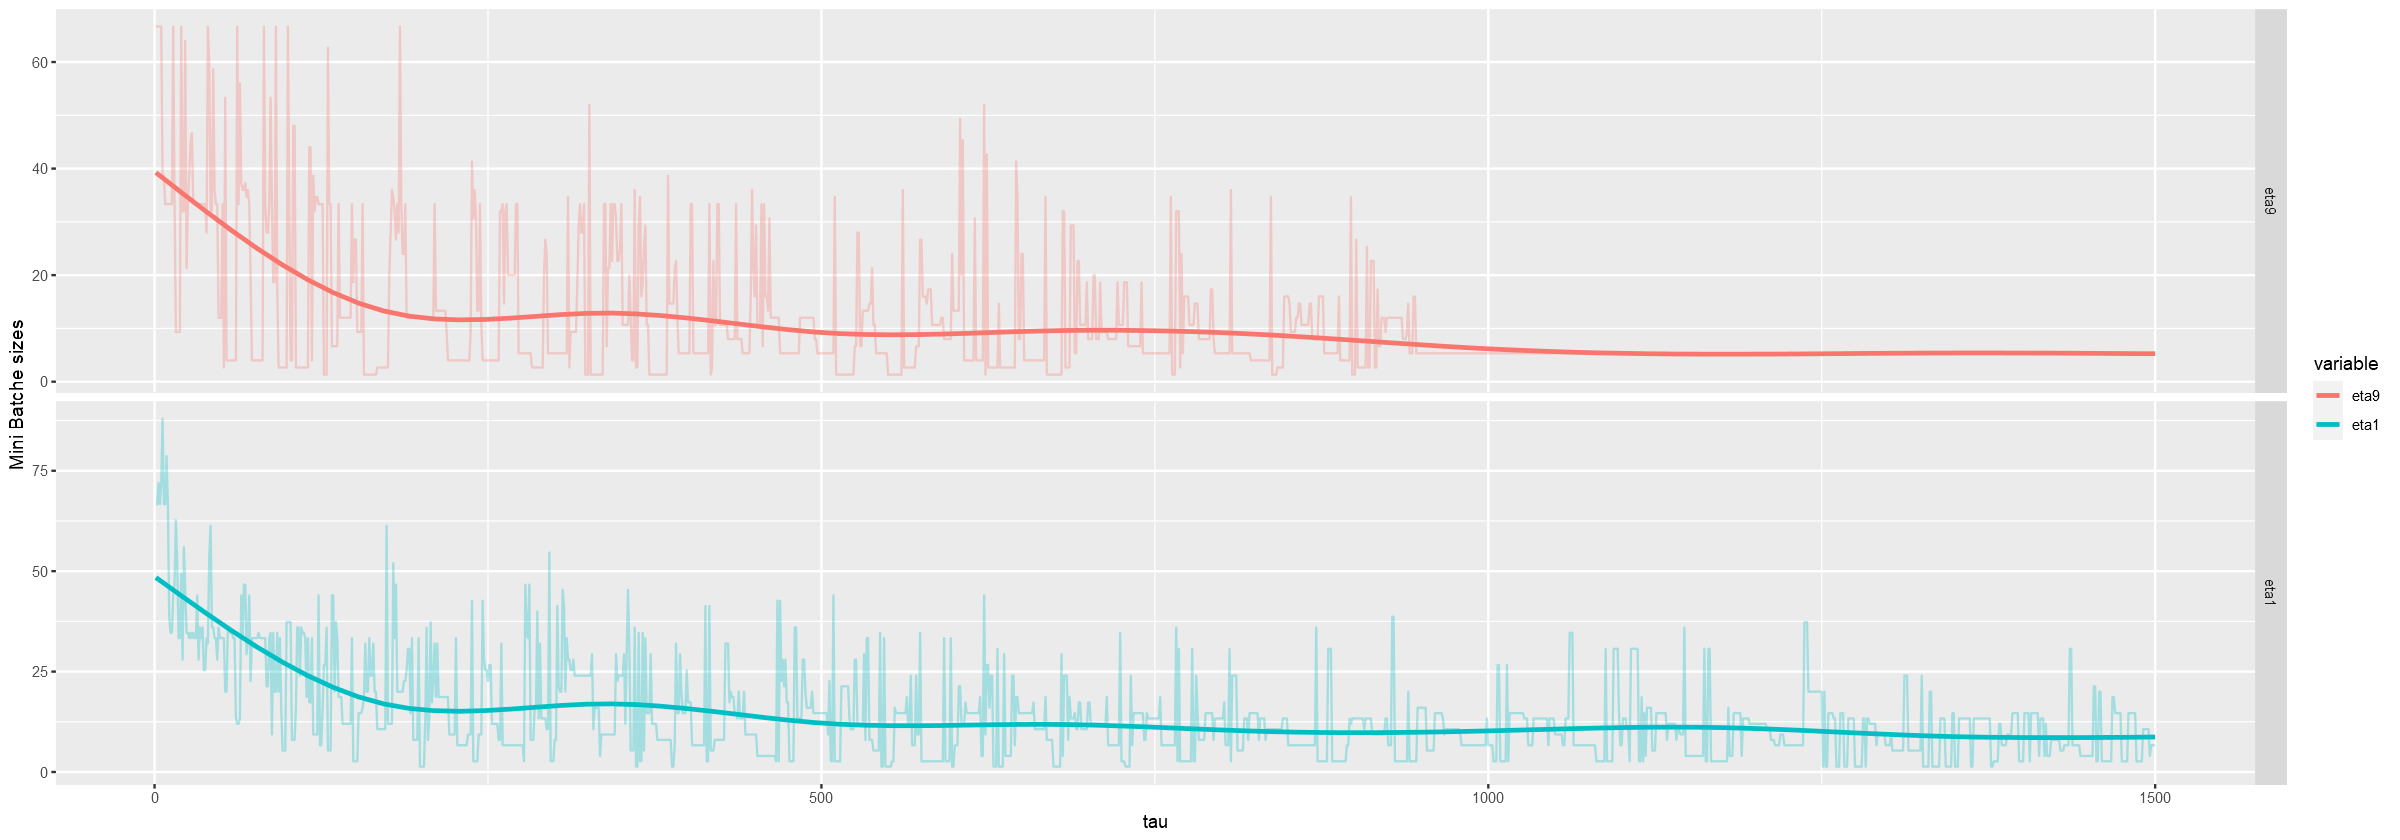

In [20]:
# read data
train_data <- read_data('Task1D_train.csv')
test_data <- read_data('Task1D_test.csv')

# trained perceptron using different eta value
eta9 <- train_multiclass_perceptron(train_data, test_data, eta=.09)
eta1 <- train_multiclass_perceptron(train_data, test_data, eta=.01)

# make plot's area wider
options(repr.plot.width=20)

# combine both model error matrices for plotting
data <- setNames(data.frame(cbind(1:nrow(eta9),eta9[,2],eta1[,2])),c('tau','eta9','eta1'))
data <- melt(data,id.vars = 'tau', measure.vars = c("eta9", "eta1"))

# plot the result using line graph and smooth line
ggplot(data,aes(tau,value, color=variable)) +
    geom_line(alpha=.3)+
    facet_grid(variable~., scales = 'free_y') +
    geom_smooth(se=FALSE) +
    ylab('Missclassifications rate') + ylab('Mini Batche sizes')




For red line which corresponds to SGD with .09 as value of $\eta$ and the blue line for SGD with .01 as value of $\eta$ show that the model learns how to classified the testing data with SGD algorithm so that model error rate is decreasing on each mini batch iterations and trained until its converging and the error rate lines stop fluctuating becomes minimal. Although both lines have shown a decreasing trend, the error lines goes up and down on each batch learned as SGD algorithm only uses one missclassified data for updating each of classifier.

The different between red and blue lines is clearly be seen on the left side. The red line is more wildly and goes up and down around its trend line, whereas the blue line has gentler movement around its trend line. That difference is because we used higher value of learning rate ($\eta$) to train the model for the red line. Higher $\eta$ means that classification weights updated by thehigher margin on each missclassification found and they are to be updated beyond the optimum weights that give the lowest error rate. In contrast, lower $\eta$ value makes each weight updating process go much more gently.